## 1. Darwin's bibliography
<p><img src="https://assets.datacamp.com/production/project_607/img/CharlesDarwin.jpg" alt="Charles Darwin" width="300px"></p>
<p>Charles Darwin is one of the few universal figures of science. His most renowned work is without a doubt his "<em>On the Origin of Species</em>" published in 1859 which introduced the concept of natural selection. But Darwin wrote many other books on a wide range of topics, including geology, plants or his personal life. In this project, a mol will be built to automatically detect how closely related his books are to each other.</p>
<p>To this purpose,  develop the bases of <strong>a content-based book recommendation system</strong>, which will determine which books are close to each other based on how similar the discussed topics are. The methods used are commonly used in text- or documents-heavy industries such as legal, tech or customer support to perform some common task such as text classification or handling search engine queries.</p>

In [215]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [216]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import re, os
import glob
import pickle
import pprint

from nltk.stem import PorterStemmer
from gensim import corpora
from gensim.models import TfidfModel
from gensim import similarities
from scipy.cluster import hierarchy


In [217]:
# The books files are contained in this folder
folder = "/content/drive/MyDrive/datasets/"

# List all the .txt files and sort them alphabetically
files = glob.glob(folder + '*.txt')

files.sort()

In [218]:
# View files
print(f'There are {len(files)} text files')

print(files[:5])

There are 20 text files
['/content/drive/MyDrive/datasets/Autobiography.txt', '/content/drive/MyDrive/datasets/CoralReefs.txt', '/content/drive/MyDrive/datasets/DescentofMan.txt', '/content/drive/MyDrive/datasets/DifferentFormsofFlowers.txt', '/content/drive/MyDrive/datasets/EffectsCrossSelfFertilization.txt']


## 2. Load the contents of each book
<p>As a first step, the contents of these books(collection of texts - corpus) are loaded and some basic pre-processing is done to facilitate the downstream analyses.</p>

In [219]:
# Initialize the object that will contain the texts and titles
# The titles for these books are stored for future reference
# and their  respective length  printed to get a gauge for their contents.

txts = []
titles = []

for file in files:
    # Open each file
    f = open(file, encoding='utf-8-sig')
    content =  f.read()

    # Remove all non-alpha-numeric characters
    _content = re.sub('[\W]+',' ',content)

    # Store the texts and titles of the books in two separate lists
    txts.append(_content)
    titles.append(os.path.basename(file).replace('.txt', ''))

# Print the length, in characters, of each book
[len(t) for t in txts]

[123235,
 496068,
 1776539,
 617088,
 913713,
 624665,
 335920,
 525423,
 797401,
 901406,
 1047518,
 1010645,
 773930,
 1678048,
 298319,
 916536,
 1093606,
 1046071,
 341447,
 1149668]

In [220]:
# View of th first 500 characters of the first document
pprint.pprint(txts[0][:500])

(' THE AUTOBIOGRAPHY OF CHARLES DARWIN From The Life and Letters of Charles '
 'Darwin By Charles Darwin Edited by his Son Francis Darwin My father s '
 'autobiographical recollections given in the present chapter were written for '
 'his children and written without any thought that they would ever be '
 'published To many this may seem an impossibility but those who knew my '
 'father will understand how it was not only possible but natural The '
 'autobiography bears the heading Recollections of the Development of my ')


## 3. Find "On the Origin of Species"
<p>For the next parts of this analysis, the results returned by the method used for a given book will checked. For consistency, Darwin's most famous book: "<em>On the Origin of Species</em> will be used."</p>

In [221]:
# Browse the list containing all the titles
ori = 0
for i in range(len(titles)):
    # Store the index if the title is "OriginofSpecies"
    if titles[i] == "OriginofSpecies":
        ori = i


# Print the stored index
print(ori)

15


## 4. Tokenize the corpus
<p>As a next step, the corpus needs to be transformed into a format that is easier to deal with for the downstream analyses. The corpus is tokenized, i.e., transform each text into a list of the individual words (called tokens) it is made of.</em>".</p>

In [222]:
# Define a list of stop words
stoplist = set('for a of the and to in to be which some is at that we i who whom show via may my our might as well'.split())

# Convert the text to lower case
txts_lower_case = [text.lower() for text in txts]

# Transform the text into tokens
txts_split = [article.split() for article in txts_lower_case]


# Remove tokens which are part of the list of stop words
texts = [[word for word in list_words if word not in stoplist] for list_words in txts_split]

# Print the first 20 tokens for the "On the Origin of Species" book
print(texts[15][:20])

['on', 'origin', 'species', 'but', 'with', 'regard', 'material', 'world', 'can', 'least', 'go', 'so', 'far', 'this', 'can', 'perceive', 'events', 'are', 'brought', 'about']


## 5. Stemming of the tokenized corpus
<p>If you have read <em>On the Origin of Species</em>, you will have noticed that Charles Darwin can use different words to refer to a similar concept. For example, the concept of selection can be described by words such as <em>selection</em>, <em>selective</em>, <em>select</em> or <em>selects</em>. This will dilute the weight given to this concept in the book and potentially bias the results of the analysis.</p>
<p>To solve this issue, it is a common practice to use a <strong>stemming process</strong>, which will group together the inflected forms of a word so they can be analysed as a single item: <strong>the stem</strong>. In our <em>On the Origin of Species</em>the words related to the concept of selection would be gathered under the <em>select</em> stem.</p>

In [223]:
# Create an instance of a PorterStemmer object
porter = PorterStemmer()

# For each token of each text, we generated its stem
texts_stem = [[porter.stem(token) for token in text] for text in texts]

# Save to pickle file
pickle.dump(texts_stem, open( "/content/drive/MyDrive/datasets/texts_stem.p", "wb" ) )


# Load the stemmed tokens list from the pregenerated pickle file
texts_stem = pickle.load(open('/content/drive/MyDrive/datasets/texts_stem.p', 'rb'))

# Print the 20 first stemmed tokens from the "On the Origin of Species" book
print(texts_stem[15][:20])

['on', 'origin', 'speci', 'but', 'with', 'regard', 'materi', 'world', 'can', 'least', 'go', 'so', 'far', 'thi', 'can', 'perceiv', 'event', 'are', 'brought', 'about']


## 6. Building a bag-of-words model
<p>Now that the texts have been transformed into stemmed tokens, models need to built that will be useable by downstream algorithms.</p>
<p>Firstly, creating a universe of all words contained in the corpus of Charles Darwin's books, which we call <em>a dictionary</em>. Then, using the stemmed tokens and the dictionary, create <strong>bag-of-words models</strong> (BoW) of each of our texts. The BoW models will represent the books as a list of all uniques tokens they contain associated with their respective number of occurrences. </p>
<p>To better understand the structure of such a model, the five first elements is printed of one of the "<em>On the Origin of Species</em>" BoW model.</p>

In [224]:
# Load the functions allowing to create and use dictionaries
# Create a dictionary from the stemmed tokens
dictionary = corpora.Dictionary(texts_stem)


# Create a bag-of-words model for each book, using the previously generated dictionary
bows = [dictionary.doc2bow(text) for text in texts_stem]

# Print the first five elements of the On the Origin of species' BoW model
print(bows[15][:5])

[(0, 11), (5, 51), (6, 1), (8, 2), (21, 1)]


## 7. The most common words of a given book
<p>The results returned by the bag-of-words model is certainly easy to use for a computer but hard to interpret for a human. It is not straightforward to understand which stemmed tokens are present in a given book from Charles Darwin, and how many occurrences that can be found.</p>
<p>In order to better understand how the model has been generated and visualize its content, it will be transformed into a DataFrame and then display the 10 most common stems for the book "<em>On the Origin of Species</em>".</p>

In [225]:
# Convert the BoW model for "On the Origin of Species" into a DataFrame
df_bow_origin = pd.DataFrame(bows[15])

# Add the column names to the DataFrame
df_bow_origin.columns = ['index','occurrences']

# Add a column containing the token corresponding to the dictionary index
df_bow_origin['token'] = [dictionary[ind] for ind in df_bow_origin['index']]

# Sort the DataFrame by descending number of occurrences and print the first 10 values
print(df_bow_origin.sort_values(by=['occurrences'] ,ascending=False)[:10])

      index  occurrences  token
747    1169         2023   have
1117   1737         1544     on
1487   2289         1542  speci
891    1367         1480     it
238     394         1362     by
1126   1748         1201     or
125     220         1140    are
664    1044         1137   from
1772   2704         1000   with
1607   2453          962    thi


## 8. Build a tf-idf model
<p>If it wasn't for the presence of the stem "<em>speci</em>", it would have been difficult to guess this BoW model comes from the <em>On the Origin of Species</em> book. The most recurring words are, apart from few exceptions, very common and unlikely to carry any information peculiar to the given book. An additional step is used in order to determine which tokens are the most specific to a book.</p>
<p>To do so, the <strong>tf-idf model</strong> (term frequency–inverse document frequency) is used. This model defines the importance of each word depending on how frequent it is in this text and how infrequent it is in all the other documents. As a result, a high tf-idf score for a word will indicate that this word is specific to this text.</p>
<p>After computing those scores, the 10 words most specific to the "<em>On the Origin of Species</em>" book will be printed (i.e., the 10 words with the highest tf-idf score).</p>

In [226]:
# Generate the tf-idf model
model = TfidfModel(bows)

# Print the model for some contents of "On the Origin of Species"
print(model[bows[15][:10]])

[(8, 0.05866486502447224), (21, 0.1645130240887821), (23, 0.4926925035555168), (27, 0.18587519434553504), (28, 0.7390387553332751), (31, 0.2463462517777584), (35, 0.29211923924062844)]


## 9. The results of the tf-idf model
<p>Once again, the format of those results is hard to interpret for a human. Therefore, it will be transformed into a more readable version and the 10 most specific words displayed for the "<em>On the Origin of Species</em>" book.</p>

In [227]:
# Convert the tf-idf model for "On the Origin of Species" into a DataFrame
df_tfidf = pd.DataFrame(model[bows[15]])

# Name the columns of the DataFrame id and score
df_tfidf.columns=['id','score']

# Add the tokens corresponding to the numerical indices for better readability
df_tfidf['token'] = [dictionary[ind] for ind in list(df_tfidf['id'])]

# Sort the DataFrame by descending tf-idf score and print the first 10 rows.
print(df_tfidf.sort_values(by=['score'], ascending=False)[:10])

         id     score    token
879    2165  0.323034   select
3100  10110  0.202055   pigeon
127     370  0.195925    breed
2982   9397  0.165974   migrat
946    2326  0.146840   steril
284     753  0.144663   domest
3668  14077  0.130376        _
503    1256  0.126405   hybrid
370     967  0.125527   fertil
3864  16581  0.123261  gärtner


## 10. Compute distance between texts
<p>The results of the tf-idf algorithm now return stemmed tokens which are specific to each book. It can be seen that topics such as selection, breeding or domestication are defining "<em>On the Origin of Species</em>" (and in this book, Charles Darwin talks quite a lot about pigeons too). Now that a model has been developed, associating tokens to how specific they are to each book, next step is taking a measure of how related the books are between each other.</p>
<p>To this purpose, a measure of similarity called the <strong>cosine similarity</strong> is used and the results visualized as a distance matrix, i.e., a matrix showing all pairwise distances between Darwin's books.</p>

In [228]:
# Compute the similarity matrix (pairwise distance between all texts)
sims = similarities.MatrixSimilarity(model[bows])

# Transform the resulting list into a dataframe
sim_df = pd.DataFrame(list(sims))

# Add the titles of the books as columns and index of the dataframe
sim_df.columns  = titles
sim_df.index = titles

# view result for the first two indexes of the resulting matrix
print(sim_df[:2])

               Autobiography  CoralReefs  DescentofMan  \
Autobiography       1.000000    0.049597      0.080753   
CoralReefs          0.049597    1.000000      0.009516   

               DifferentFormsofFlowers  EffectsCrossSelfFertilization  \
Autobiography                 0.066496                       0.076738   
CoralReefs                    0.001981                       0.001937   

               ExpressionofEmotionManAnimals  FormationVegetableMould  \
Autobiography                       0.088927                 0.041152   
CoralReefs                          0.005048                 0.029451   

               FoundationsOriginofSpecies  GeologicalObservationsSouthAmerica  \
Autobiography                    0.026507                            0.030605   
CoralReefs                       0.010080                            0.060813   

               InsectivorousPlants  LifeandLettersVol1  LifeandLettersVol2  \
Autobiography             0.014920            0.399303         

## 11. The book most similar to "On the Origin of Species"
<p>The similarity matrix contains all the similarity measures between any pair of books from Charles Darwin! It can be used to extract the information the distance between one book and one or several others. </p>
<p>As a first step, the books with the most similarity to "<em>On the Origin of Species</em>," will be displayed, more specifically, a bar chart showing all books ranked by how similar they are to Darwin's landmark work.</p>

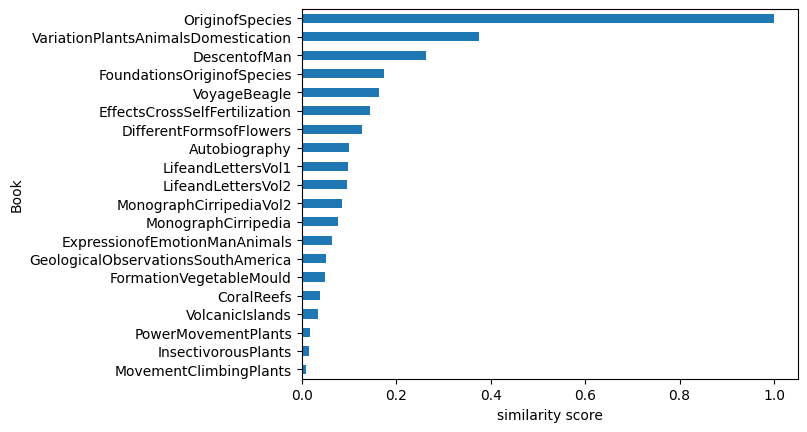

<Figure size 1000x600 with 0 Axes>

In [229]:
%matplotlib inline

# Select the column corresponding to "On the Origin of Species"
v = sim_df['OriginofSpecies']

# Sort by ascending scores
v_sorted = v.sort_values()

# Plotting data as a horizontal bar plot
ax = v_sorted.plot.barh()

# Modify the axes labels and plot title for a better readability
plt.figure(figsize=(10,6))
ax.set_xlabel('similarity score')
ax.set_ylabel('Book')
ax.set_title = 'Similarity plot of Books with "On the Origin of Species"'

plt.show()


## 12. Which books have similar content?
<p>The chart is extremely useful in determining a given book's most similar work. For example, if someone has  enjoyed "<em>On the Origin of Species</em>," the person could read books discussing similar concepts such as "<em>The Variation of Animals and Plants under Domestication</em>" or "<em>The Descent of Man, and Selection in Relation to Sex</em>." Indeed, <em>On the Origin of Species</em> has a whole chapter about domestication and <em>The Descent of Man, and Selection in Relation to Sex</em> applies the theory of natural selection to human evolution. Hence, the results make sense.</p>
<p>However, it is necessary to have a better understanding of the big picture and see how Darwin's books are generally related to each other (in terms of topics discussed). To this purpose, the whole similarity matrix will be represented as a dendrogram, which is a standard tool to display such data. <strong>This last approach will display all the information about book similarities at once.</strong> For example, a book's closest relative can be found, but, also, groups of books that have similar can be visualised topics  (e.g., the cluster about Charles Darwin personal life with his autobiography and letters). If familiar with Darwin's bibliography, the results would not be surprising, which indicates the method gives good results. Otherwise, this could suggest which book to read next after reading one of the author's book, someone will know which other books to read next in order to learn more about the topics it addressed.</p>

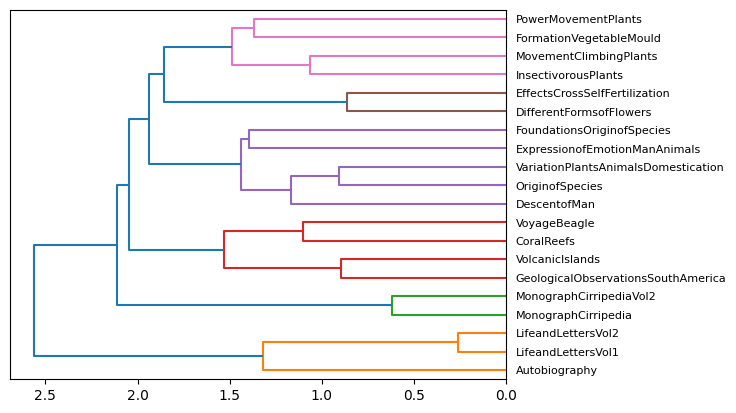

In [230]:
# Compute the clusters from the similarity matrix,
# using the Ward variance minimization algorithm
Z = hierarchy.linkage(sims,'ward')

# Display this result as a horizontal dendrogram
x = hierarchy.dendrogram(Z,leaf_font_size=8,labels=sim_df.index,orientation="left")

plt.show()